<a href="https://colab.research.google.com/github/callumselv/Y4_project/blob/main/Lohani_2021_fidelity_metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 22.6 MB/s eta 0:00:00


In [2]:
import numpy as np
from qutip import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from scipy.stats import unitary_group

In [3]:
no_data = 30000
d = 2
dimension = 2**d

In [4]:
def gen_rhos_chos(no_data, d):
    dimension = 2**d
    rhos = np.zeros((no_data,dimension,dimension),dtype=complex)

    eta = 1e-7

    # Generate random density matrices with eta adjustment to avoid issues in Cholesky decomposition
    for i in range(no_data):
        random_unitary = unitary_group.rvs(dimension)
        coeffs = random_unitary[:,0]
        rho = np.outer(coeffs,coeffs.conj())
        rhos[i] = (1-eta)*rho + (eta/4)*np.eye(dimension)

    # Calculate Cholesky decomposition of density matrices
    cholesky_decompositions = np.array([np.linalg.cholesky(rho) for rho in rhos])

    return rhos,cholesky_decompositions

In [5]:
def generate_index_pairs(d):
    dimension = 2**d
    index_num = int(dimension*(dimension-1)/2)
    pairs = np.zeros((index_num,2), dtype=int)
    index=0
    for diff in range(1, dimension):
        for i in range(diff, dimension):
            j = i - diff
            pairs[index] = (i, j)
            index+=1

    return pairs

In [6]:
ind = generate_index_pairs(d)
ind

array([[1, 0],
       [2, 1],
       [3, 2],
       [2, 0],
       [3, 1],
       [3, 0]])

In [7]:
def gen_taus(no_data, d):
    rhos, cholesky_decompositions = gen_rhos_chos(no_data, d)

    dimension = 2**d
    tau_size = dimension**2

    all_taus = np.zeros((no_data, tau_size))
    indices = generate_index_pairs(d)

    for no in range(no_data):
        cholesky = cholesky_decompositions[no]
        extracted_values = np.zeros(tau_size)

        index=0
        for i in range(cholesky.shape[0]):
            extracted_values[i] = cholesky[i, i].real

        index = cholesky.shape[0]
        for i, j in indices:
            extracted_values[index] = cholesky[i, j].real
            extracted_values[index + 1] = cholesky[i, j].imag
            index += 2

        all_taus[no] = extracted_values

    return all_taus

In [8]:
def gen_nvals_taus_rhos(no_data, d):
    rhos, cholesky_decompositions = gen_rhos_chos(no_data, d)

    dimension = 2**d
    tau_size = dimension**2

    all_taus = np.zeros((no_data, tau_size))
    indices = generate_index_pairs(d)

    for no in range(no_data):
        cholesky = cholesky_decompositions[no]
        extracted_values = np.zeros(tau_size)

        index_tau=0
        for i in range(cholesky.shape[0]):
            extracted_values[i] = cholesky[i, i].real

        index_tau = cholesky.shape[0]
        for i, j in indices:
            extracted_values[index_tau] = cholesky[i, j].real
            extracted_values[index_tau + 1] = cholesky[i, j].imag
            index_tau += 2

        all_taus[no] = extracted_values

    nvals = np.zeros((no_data,6**d))

    for i1,rho in enumerate(rhos):
      for index,proj in enumerate(pauli_2d):
          nvals[i1,index] = np.trace(rho@proj)

    return nvals, all_taus, rhos

In [ ]:
2**(2*d)

16

In [9]:
# Make 6^d projectors of Pauli {X,Y,Z} operators

paulis = [sigmax(),sigmay(),sigmaz()]
evectors = np.zeros((6,2,1),dtype=complex)

i=0
for pauli in paulis:
    vals, vecs = pauli.eigenstates()
    evectors[i] = vecs[0][:]
    evectors[i+1] = vecs[1][:]
    i += 2

projectors = np.zeros((6,2,2), dtype=complex)

for i, vectors in enumerate(evectors):
    projectors[i] = np.outer(vectors,vectors.conj())

In [10]:
pauli_2d = np.zeros((6**2,4,4), dtype=complex)

index=0
for i in projectors:
    for j in projectors:
        pauli_2d[index] = np.kron(i,j)
        index += 1

In [11]:
pauli_3d = np.zeros((6**3,2**3,2**3), dtype=complex)

index=0
for i in pauli_2d:
    for j in projectors:
        pauli_3d[index] = np.kron(i,j)
        index += 1

In [12]:
def reconstruct_matrix_nn(taus):
    matrix = np.zeros((dimension, dimension), dtype=np.complex_)

    index = 0
    for i in range(dimension):
        matrix[i, i] = taus[index]
        index += 1

    indices = generate_index_pairs(d)

    for i, j in indices:
        real_part = taus[index]
        imag_part = taus[index + 1]
        matrix[i, j] = real_part + 1j * imag_part
        index += 2

    rho = matrix@(matrix.conj().T)
    rho = rho/np.trace(rho)

    return rho

In [13]:
def reconstruct_matrix_t(taus):
    matrix = np.zeros((dimension, dimension), dtype=np.complex_)

    index = 0
    for i in range(dimension):
        matrix[i, i] = taus[index]
        index += 1

    indices = generate_index_pairs(d)

    for i, j in indices:
        real_part = taus[index]
        imag_part = taus[index + 1]
        matrix[i, j] = real_part + 1j * imag_part
        index += 2

    rho = matrix@(matrix.conj().T)

    return rho

In [22]:
def generate_index_pairs_tf(d):
    dimension = 2 ** d
    pairs_list = []
    for diff in range(1, dimension):
        for i in range(diff, dimension):
            j = i - diff
            pairs_list.append([i, j])
    pairs = tf.constant(pairs_list, dtype=tf.int32)
    return pairs

def reconstruct_matrix_nn_tf(taus, d):
    dimension = 2 ** d

    diag_indices = tf.stack([tf.range(dimension), tf.range(dimension)], axis=1)
    diag_values = tf.cast(taus[:, :dimension], tf.complex64)

    indices = generate_index_pairs_tf(d)
    num_pairs = tf.shape(indices)[0]
    index = dimension

    real_parts = tf.cast(taus[:, index : index + num_pairs], tf.complex64)
    imag_parts = tf.cast(taus[:, index + num_pairs : index + 2 * num_pairs], tf.complex64)
    off_diag_values = real_parts + 1j * imag_parts

    batch_size = tf.shape(taus)[0]
    diag_indices = tf.tile(tf.expand_dims(diag_indices, 0), [batch_size, 1, 1])
    diag_values = tf.expand_dims(diag_values, -1)

    off_diag_indices = tf.tile(tf.expand_dims(indices, 0), [batch_size, 1, 1])
    off_diag_values = tf.expand_dims(off_diag_values, -1)

    all_indices = tf.concat([diag_indices, off_diag_indices], axis=1)
    all_values = tf.concat([diag_values, off_diag_values], axis=1)

    matrix_shape = [dimension, dimension]
    matrices = tf.map_fn(
        lambda x: tf.scatter_nd(x[0], tf.squeeze(x[1]), matrix_shape),
        (all_indices, all_values),
        fn_output_signature=tf.complex64
    )

    # Compute rho = matrix @ matrix.conj().T
    matrices_dagger = tf.linalg.adjoint(matrices)
    rhos = tf.matmul(matrices, matrices_dagger)

    traces = tf.linalg.trace(rhos)
    traces = tf.reshape(traces, [-1, 1, 1])
    rhos_normalized = rhos / traces

    return rhos_normalized

def reconstruct_matrix_t_tf(taus, d):
    dimension = 2 ** d

    diag_indices = tf.stack([tf.range(dimension), tf.range(dimension)], axis=1)
    diag_values = tf.cast(taus[:, :dimension], tf.complex64)

    indices = generate_index_pairs_tf(d)
    num_pairs = tf.shape(indices)[0]
    index = dimension

    real_parts = tf.cast(taus[:, index : index + num_pairs], tf.complex64)
    imag_parts = tf.cast(taus[:, index + num_pairs : index + 2 * num_pairs], tf.complex64)
    off_diag_values = real_parts + 1j * imag_parts

    batch_size = tf.shape(taus)[0]
    diag_indices = tf.tile(tf.expand_dims(diag_indices, 0), [batch_size, 1, 1])
    diag_values = tf.expand_dims(diag_values, -1)

    off_diag_indices = tf.tile(tf.expand_dims(indices, 0), [batch_size, 1, 1])
    off_diag_values = tf.expand_dims(off_diag_values, -1)

    all_indices = tf.concat([diag_indices, off_diag_indices], axis=1)
    all_values = tf.concat([diag_values, off_diag_values], axis=1)

    matrix_shape = [dimension, dimension]
    matrices = tf.map_fn(
        lambda x: tf.scatter_nd(x[0], tf.squeeze(x[1]), matrix_shape),
        (all_indices, all_values),
        fn_output_signature=tf.complex64
    )

    # Compute rho = matrix @ matrix.conj().T
    matrices_dagger = tf.linalg.adjoint(matrices)
    rhos = tf.matmul(matrices, matrices_dagger)

    return rhos

'''
def fidelity_tf(rho_t, rho_nn):
    sqrt_nn = tf.linalg.sqrtm(rho_nn)
    intermediate = tf.matmul(sqrt_nn, tf.matmul(rho_t, sqrt_nn))
    sqrt_intermediate = tf.linalg.sqrtm(intermediate)
    trace = tf.math.real(tf.linalg.trace(sqrt_intermediate))
    fidelity = tf.square(tf.abs(trace))
    return fidelity
'''

def fidelity_tf(rho_t, rho_nn):
    product = tf.matmul(rho_t, rho_nn)
    trace = tf.linalg.trace(product)
    return tf.abs(trace)


def fid_taus_tf(tau_t, tau_nn, d):
    rho_t = reconstruct_matrix_t_tf(tau_t, d)
    rho_nn = reconstruct_matrix_nn_tf(tau_nn, d)
    fidelities = fidelity_tf(rho_t, rho_nn)
    return fidelities

In [23]:
def fidelity_metric(y_true, y_pred):
    return fid_taus_tf(y_true, y_pred, d)

In [16]:
dense1 = 750
dense2 = 450

In [18]:
def build_cnn_model():
    model = Sequential()

    model.add(tf.keras.layers.Reshape((6, 6, 1), input_shape=(36,)))

    model.add(Conv2D(filters=25, kernel_size=(2, 2), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=25, kernel_size=(2, 2), strides=1, activation='relu'))

    model.add(Flatten())

    model.add(Dense(dense1, activation='relu'))

    model.add(Dense(dense2, activation='relu'))

    model.add(Dense(2**(2*d), activation='linear'))

    return model

model = build_cnn_model()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 6, 6, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 25)            │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2, 2, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1, 1, 25)            │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 750)                 │          19,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 450)                 │         337,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           7,216 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 367,316 (1.40 MB)

 Trainable params: 367,316 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
nvals,all_taus,rhos = gen_nvals_taus_rhos(30000,d)

<ipython-input-8-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [24]:
model1 = build_cnn_model()
model1.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=[fidelity_metric, 'mean_squared_error']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history1 = model1.fit(
    nvals, all_taus,
    epochs=300,
    batch_size=100,
    validation_split=0.2
    )


Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - fidelity_metric: 0.2900 - loss: 0.1166 - mean_squared_error: 0.0464 - val_fidelity_metric: 0.4301 - val_loss: 0.0901 - val_mean_squared_error: 0.0312
Epoch 2/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - fidelity_metric: 0.4523 - loss: 0.0867 - mean_squared_error: 0.0298 - val_fidelity_metric: 0.4900 - val_loss: 0.0773 - val_mean_squared_error: 0.0257
Epoch 3/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - fidelity_metric: 0.5027 - loss: 0.0741 - mean_squared_error: 0.0234 - val_fidelity_metric: 0.5238 - val_loss: 0.0667 - val_mean_squared_error: 0.0199
Epoch 4/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - fidelity_metric: 0.5278 - loss: 0.0657 - mean_squared_error: 0.0193 - val_fidelity_metric: 0.5393 - val_loss: 0.0615 - val_mean_squared_error: 0.0176
Epoch 5/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - fidelity_metric: 0.5433 - loss: 0.0599 - mean_squared_error: 0.0166 - val_fidelity_metric: 0.5526 - val_loss: 0.0568 - val_mean_squared_e

Text(0, 0.5, '1 - Fidelity')

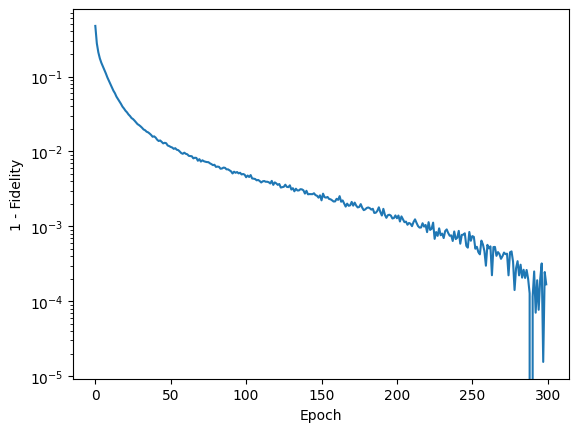

In [29]:
plt.semilogy(1-(history1.history['fidelity_metric']/np.max(history1.history['fidelity_metric'])))
plt.xlabel('Epoch')
plt.ylabel('1 - Fidelity')

In [26]:
n_tests, tau_tests, rho_tests = gen_nvals_taus_rhos(500,d)

<ipython-input-9-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [27]:
tau_nns = model1.predict(n_tests)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [29]:
fidelities = np.zeros(len(tau_nns))
index = 0
for nns, tests in zip(tau_nns,tau_tests):
  fidelities[index] = fid_taus(tests,nns)
  index += 1

In [30]:
print(f'Average fidelity over {len(tau_nns)} test matrices is {np.mean(fidelities)*100:.2f} ± {np.std(fidelities)*100/np.sqrt(len(fidelities)):.2f} %')

Average fidelity over 500 test matrices is 99.03 ± 0.12 %


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
save_dir = '/content/drive/MyDrive'

In [41]:
import os

model_save_path = os.path.join(save_dir, '2d_trained_model.keras')

In [42]:
model1.save(model_save_path)

In [ ]:
tau_nn = model.predict(nvals_t)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
print(no_data,d)

30000 2


In [23]:
from scipy.linalg import sqrtm

In [24]:
def fidelity(rho_t, rho_nn):
    sqrt_nn = sqrtm(rho_nn)
    matrix = sqrt_nn@rho_t@sqrt_nn
    tr = np.trace(sqrtm(matrix))
    return np.abs(tr)**2

In [25]:
def fid_taus(tau_t, tau_nn):
    rho_t = reconstruct_matrix_t(tau_t)
    rho_nn = reconstruct_matrix_nn(tau_nn)
    return fidelity(rho_t, rho_nn)

In [ ]:
fidelity(test_rhos[0], rho_nn)

0.99948127099706151087